<a href="https://colab.research.google.com/github/HayateSato/DS_Practice/blob/main/Bean_imageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import hashlib
from collections import Counter # count the occurrences of each class label in image dataset
from PIL import Image #image processing


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

train_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/train'
test_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/test'
vali_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/validation'

working_dir = train_path
os.chdir(working_dir)
os.listdir(working_dir)

Mounted at /content/drive


['angular_leaf_spot', 'healthy', 'bean_rust']

# EDA


In [3]:
# Create datasets for each split
train_ds = tf.keras.utils.image_dataset_from_directory(train_path)
val_ds = tf.keras.utils.image_dataset_from_directory(vali_path)
test_ds = tf.keras.utils.image_dataset_from_directory(test_path)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

Distribution of Classes.
====

Goal: Check if the dataset is balanced across the three classes: Angular Leaf Spot, Bean Rust, and Healthy.

In [5]:
# import numpy as np
# from collections import Counter

# Get class names from the dataset
class_names = train_ds.class_names

# Iterate through the dataset to collect labels
class_labels = []
for images, labels in train_ds:  # Unpack images and labels from the dataset
    class_labels.extend(labels.numpy())  # Convert labels to NumPy array and extend the list

class_counts = Counter(class_labels)

# Print class distribution
print("Class Distribution:", class_counts)

Class Distribution: Counter({1: 348, 0: 345, 2: 341})


In [6]:
# Get class names from the dataset
class_names = train_ds.class_names

# Iterate through the train_ds to collect labels
class_labels = []
for images, labels in train_ds:  # Unpack images and labels from the dataset
    class_labels.extend(labels.numpy())  # Convert labels to NumPy array and extend the list

class_counts = Counter(class_labels)

# Print class distribution with class names
for label, count in class_counts.items():
    print(f"Class label {label}:  {class_names[label]}")

Class label 1:  bean_rust
Class label 0:  angular_leaf_spot
Class label 2:  healthy


Image Data Format and Quality
===

Image shape: (256, 256, 3), Image dtype: float32


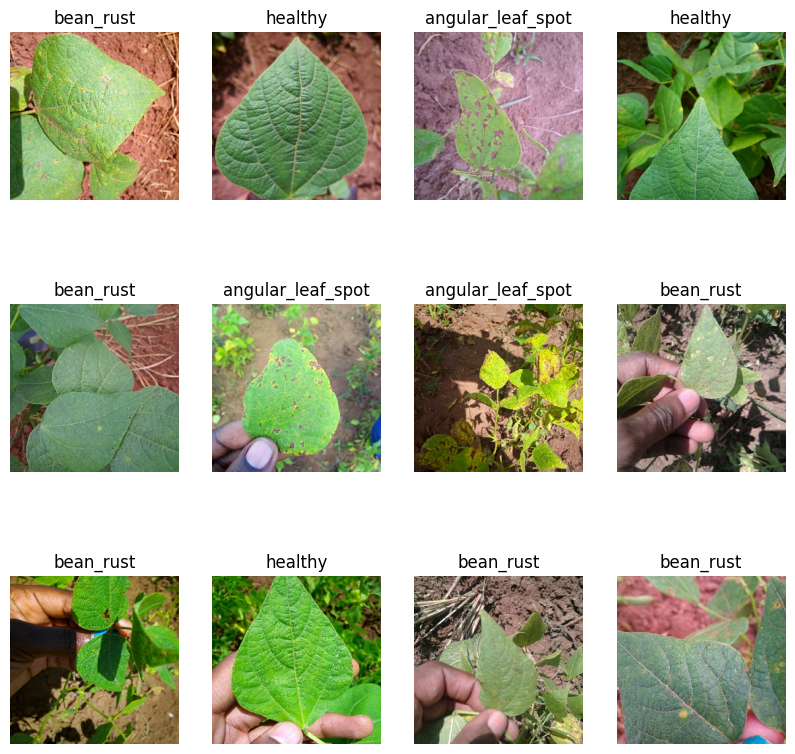

In [7]:
for images, _ in train_ds.take(1):  # Take one batch of images
    for img in images:
        img = np.array(img)  # Convert tensor to NumPy array
        print(f"Image shape: {img.shape}, Image dtype: {img.dtype}")
        break  # Checking just one image for format and size

# Unbatch the dataset to process individual images
train_ds_unbatched = train_ds.unbatch()

# Initialize the figure
plt.figure(figsize=(10, 10))

# Display 12 individual images
for i, (image, label) in enumerate(train_ds_unbatched.take(12)):  # take 12 images
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Display image
    plt.title(class_names[label])  # Display label using class names
    plt.axis("off")  # Remove axes

plt.show()


Any Missing, Corrupted, or Duplicate Images?
====

In [8]:
# Checking for corrupted images
# # !pip install tensorflow

# import tensorflow as tf
# from PIL import Image

corrupted_images = []
# Iterate through the dataset, accessing individual image paths
for images, labels in train_ds:
    for img_tensor in images:
        try:
            # Convert the tensor to a NumPy array
            img_array = img_tensor.numpy()
            # Create a PIL Image from the NumPy array
            img = Image.fromarray(img_array.astype('uint8'))
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError) as e:
            print(f"Corrupted Image: {img_tensor}")
            corrupted_images.append(img_tensor)


print(f"the number of corrupted Images: {len(corrupted_images)}")

the number of corrupted Images: 0


In [9]:
#duplicate images
# import hashlib
# import os

def file_hash(filepath):
    """Calculate the hash of a file."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicates = []
for img_name in os.listdir(train_path):
    img_path = os.path.join(train_path, img_name)
    # Check if the item is a file before calculating the hash
    if os.path.isfile(img_path):
        img_hash = file_hash(img_path)
        if img_hash in image_hashes:
            duplicates.append(img_name)
        else:
            image_hashes[img_hash] = img_name

print(f"the number of duplicate Images: {len(duplicates)}")

the number of duplicate Images: 0


Data Augmentation
===

In [13]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# Data Argumentation
resize_and_rescale = keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])

# Image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    # layers.RandomBrightness(factor=0.1),  # Adjust brightness by a factor (0.0 - 1.0)
    # layers.RandomContrast(factor=0.1),    # Adjust contrast by a factor (0.0 - 1.0)
    # # layers.RandomSaturation(factor=0.1),
    ######## add lighting / saturation of the image samples ##########
])

In [14]:
# Data enhancement
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

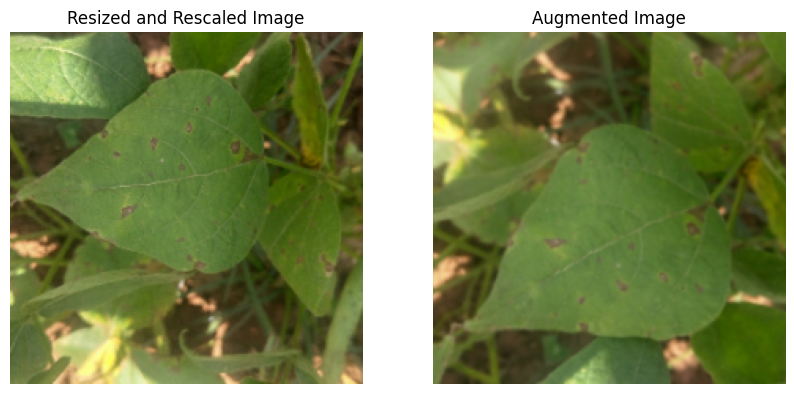

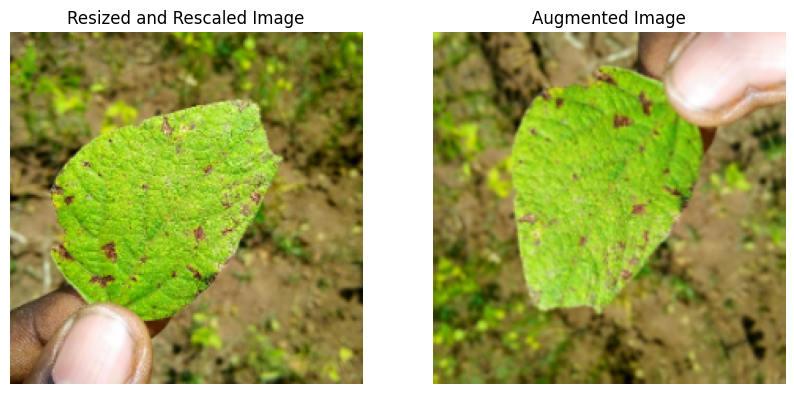

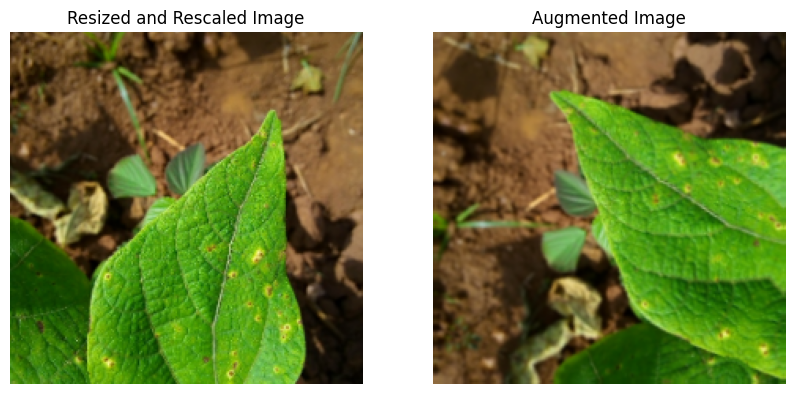

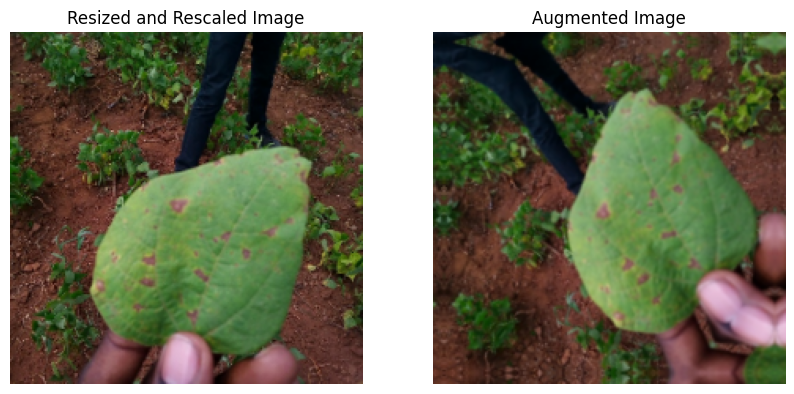

In [15]:
# Unbatch the dataset to get individual images
unbatched_ds = train_ds.unbatch()

# Take one image and its label
for image, label in unbatched_ds.take(4):
    # Apply resizing and rescaling
    resized_image = resize_and_rescale(image)

    # Apply augmentation
    augmented_image = data_augmentation(resized_image)

    # Convert both images from float32 [0,1] to uint8 [0,255] for display
    resized_image = tf.clip_by_value(resized_image * 255, 0, 255)
    resized_image = tf.cast(resized_image, tf.uint8)

    augmented_image = tf.clip_by_value(augmented_image * 255, 0, 255)
    augmented_image = tf.cast(augmented_image, tf.uint8)

    # Plot both images side by side
    plt.figure(figsize=(10, 5))

    # Show resized image
    plt.subplot(1, 2, 1)
    plt.imshow(resized_image.numpy())
    plt.title("Resized and Rescaled Image")
    plt.axis("off")

    # Show augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image.numpy())
    plt.title("Augmented Image")
    plt.axis("off")

    plt.show()